## GeoTIFF Overview

**GeoTIFF** is an extension of the TIFF file format, designed for storing georeferenced raster images.

#### Components:

- **Raster Data**: 
  - Contains the pixel values, typically representing features like elevation, reflectance, or other phenomena.
  
- **Metadata**: 
  - Provides additional information about the dataset.

#### Georeferencing:

- **GeoTransform**: 
  - A set of six parameters defining the relationship between pixel/line (row/column) space to coordinate space. This includes:
    - Top-left x coordinate
    - Width of a pixel
    - Rotation (typically 0 for north-up images)
    - Top-left y coordinate
    - Rotation (typically 0 for north-up images)
    - Height of a pixel (usually negative)
  - Using the GeoTransform, one can calculate the spatial coordinates of any pixel in the image.

#### Coordinate System:

- Defines how the 2D (or 3D) coordinates relate to actual places on the earth. Often defined using Well-Known Text (WKT) or EPSG codes.

#### Tags:

- GeoTIFF utilizes a set of reserved TIFF tags to store a full set of georeferencing metadata, ensuring data spatial integrity and accuracy.

#### Extensibility:

- Can accommodate different coordinate systems (e.g., UTM, State Plane) and various data types (e.g., byte, int, float).

#### Global Coverage:

- GeoTIFF supports global data, ensuring any location on Earth can be georeferenced within this format.

#### Compatibility:

- Being an extension of TIFF, GeoTIFF files can be read by most image viewers. However, geospatial metadata might be ignored.

In essence, the GeoTIFF format embeds the lat/lon info of each pixel using the combination of GeoTransform and the coordinate system. The GeoTransform provides pixel-to-coordinate mapping, while the coordinate system defines how those coordinates relate to real-world locations.

# Import

In [36]:
import os
from osgeo import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import cos, sin, radians, sqrt

In [2]:
sample_folder_path = "D:/CMU/Spacecraft/LandSat/landsat_c2_l1_sample/"
file = os.path.join(sample_folder_path, 'LC08_L1TP_009047_20230914_20230919_02_T1_refl.tif')
ds = gdal.Open(file)

## Raster Dataset Information and Properties
Once a raster dataset is opened, you can obtain information and metadata from the dataset to preform additional analysis. With gdal we can access many raster properties, including, projection, size (columns and rows), the number of bands, and the geotransform (upper left corner, cell width, etc.). Let’s start by obtaining the projection, size, and band count for the raster.

In [9]:
print("'ds' type", type(ds))
print("Projection: ", ds.GetProjection()) 
print("Columns:", ds.RasterXSize) 
print("Rows:", ds.RasterYSize)  
print("Band count:", ds.RasterCount)  
print("Metadata:", ds.GetMetadata()) 

'ds' type <class 'osgeo.gdal.Dataset'>
Projection:  PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]
Columns: 7541
Rows: 7711
Band count: 3
Metadata: {'AREA_OR_POINT': 'Area'}


In [11]:
# Read the raster band as separate variable
band = ds.GetRasterBand(1)

# Check type of the variable 'band'
type(band)

# Data type of the values
gdal.GetDataTypeName(band.DataType)

# Compute statistics if needed
if band.GetMinimum() is None or band.GetMaximum()is None:
    band.ComputeStatistics(0)
    print("Statistics computed.")

# Fetch metadata for the band
band.GetMetadata()

# Print only selected metadata:
print ("[ NO DATA VALUE ] = ", band.GetNoDataValue()) # none
print ("[ MIN ] = ", band.GetMinimum())
print ("[ MAX ] = ", band.GetMaximum())

Statistics computed.
[ NO DATA VALUE ] =  None
[ MIN ] =  0.0
[ MAX ] =  229.0


## GeoTransform 
The gdal GeoTransform is a tuple that contains six elements. Each GeoTransform element is expalined below in order of its pythonic index (0-5), that is, its position within the tuple.
Data from the GeoTransform are used to determine the image extent, pixel centroids and corners, and pixel addresses that correspond to geographic coordinates.

- [0] left X coordinate
- [1] pixel width
- [2] row rotation (usually zero)
- [3] top Y coordinate
- [4] column rotation (usually zero)
- [5] pixel height, this will be negative for north up images


In [5]:
print("GeoTransform", ds.GetGeoTransform())

GeoTransform (614085.0, 30.0, 0.0, 2193915.0, 0.0, -30.0)


## Read Raster Data

(7711, 7541)


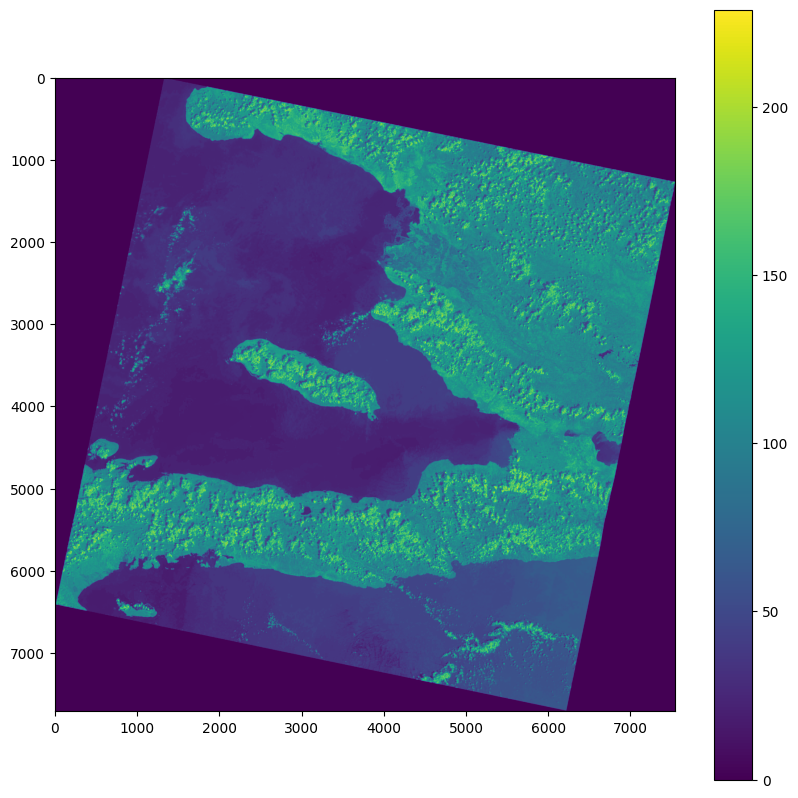

In [8]:
data_array = ds.GetRasterBand(1).ReadAsArray()
print(data_array.shape)

plt.figure(figsize=(10, 10))
plt.imshow(data_array)
plt.colorbar()

### Here's an attempt to get pixel-wise coordinates...

In [3]:
output_path = "GDAL_output"
output_xyz = os.path.join(output_path, 'output.xyz')
cropped_output_xyz = os.path.join(output_path, 'cropped_output.xyz')

# Translate to XYZ format
#gdal.Translate(output_xyz, ds, format='XYZ', creationOptions=["ADD_HEADER_LINE=YES"])

In [4]:
# Define Translate options: Crop (subset) the image by specifying [ulx, uly, lrx, lry]
projWin_16 = [614100.000, 2193900.000, 670650.000, 2136075.000]  # Replace with desired coordinates
translateOptions = gdal.TranslateOptions(format='XYZ', creationOptions=["ADD_HEADER_LINE=YES"], projWin=projWin_16)

# Translate to XYZ format with cropping
gdal.Translate(cropped_output_xyz, ds, options=translateOptions)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000024706A01140> >

In [14]:
ds_resized = None
datase_src = None
datase_dst = None

## Rotating a GeoTIFF Image

Rotating a GeoTIFF image is more intricate than a typical RGB image due to its embedded geospatial metadata.

1. **Georeferencing**: 
    - A GeoTIFF is not just a grid of pixels. Each pixel corresponds to a specific geographical location on the Earth. Rotation needs to maintain this spatial correspondence.
  
2. **GeoTransform Matrix**: 
    - GeoTIFFs come with a GeoTransform matrix, determining how pixel positions relate to real-world coordinates. Rotating the image mandates an update to this matrix.

3. **Data Interpolation**: 
    - Rotational actions introduce the need for data interpolation. This process might slightly alter the original data values, a vital concern for precision-sensitive applications.

4. **Bounding Box & Mask**: 
    - Differing from regular images where rotation might only change the image's bounding dimensions, GeoTIFF rotation can result in areas outside the initial image scope, often termed as "no data" regions. This situation might demand adjustments to image masks.

5. **Metadata Update**: 
    - After rotation, crucial metadata elements, including corner coordinates, bounding boxes, and potentially coordinate system definitions, might require an update.

### Here's some attempts to rotate the GeoTiFF...

#### Rotate using Affine Transformation

In [91]:
from affine import Affine

sample_folder_path = "D:/CMU/Spacecraft/LandSat/landsat_c2_l1_sample/"
file = os.path.join(sample_folder_path, 'LC08_L1TP_009047_20230914_20230919_02_T1_refl.tif')

output_path = "GDAL_output"
rotated_image_path = os.path.join(output_path, 'rotated_image.tif')
resized_image_path = os.path.join(output_path, 'resized_image.tif')
#resized_image_path = file

def raster_center(raster):
    """This function return the pixel coordinates of the raster center 
    """

    # We get the size (in pixels) of the raster
    # using gdal
    width, height = raster.RasterXSize, raster.RasterYSize

    # We calculate the middle of raster
    xmed = width / 2
    ymed = height / 2

    return (xmed, ymed)


def rotate_gt(affine_matrix, angle, pivot=None):
    """This function generate a rotated affine matrix
    """

    # The gdal affine matrix format is not the same
    # of the Affine format, so we use a bullit-in function
    # to change it
    # see : https://github.com/sgillies/affine/blob/master/affine/__init__.py#L178
    affine_src = Affine.from_gdal(*affine_matrix)
    # We made the rotation. For this we calculate a rotation matrix,
    # with the rotation method and we combine it with the original affine matrix
    # Be carful, the star operator (*) is surcharged by Affine package. He make
    # a matrix multiplication, not a basic multiplication
    affine_dst = affine_src * affine_src.rotation(angle, pivot)
    # We retrun the rotated matrix in gdal format
    return affine_dst.to_gdal()


# Import the raster to rotate
# Here I use a sample of GDAL, dowloaded here : https://download.osgeo.org/geotiff/samples/spot/chicago/SP27GTIF.TIF
# and transformed in nc with qgis
# NB: the transformation in nc is specific for the original question,
# this step is not neccecary if you copy/past this code
dataset_src = gdal.Open(resized_image_path)

# For no overwriting the original raster I make a copy

# I Get the reading/writing driver (GTIFF)
driver = gdal.GetDriverByName("GTiff")
# A new raster, the destination file, is created.
# This raster is a copy of the source raster (same size, values...)
datase_dst = driver.CreateCopy(rotated_image_path, dataset_src, strict=0)

# Now we can rotate the raster

# First step, we get the affine tranformation matrix of the initial fine
# More info here : https://gdal.org/tutorials/geotransforms_tut.html#geotransforms-tut
gt_affine = dataset_src.GetGeoTransform()
print(f"GetGeoTransform() before rotating: ", dataset_src.GetGeoTransform())

# Second we get the center of the raster to set the rotation center
# Be carefull, the center is in pixel number, not in projected coordinates
# More info on the  "raster_center" comment's
center = raster_center(dataset_src)
print(f"center of image: ", center)

# Third we rotate the destination raster, datase_dst, with setting a new
# affine matrix made by the "rotate_gt" function.
# gt_affine is the initial affine matrix
# -33 is an exemple angle (in degrees)
# and center the center of raster
datase_dst.SetGeoTransform(rotate_gt(gt_affine, -11, center))

# Now warp (resample) the dataset to effectively apply the rotation to the raster data
warp_options = gdal.WarpOptions(resampleAlg=gdal.GRA_Bilinear, 
                                dstSRS=dataset_src.GetProjection(), 
                                srcAlpha=False)

gdal.Warp(rotated_image_path, 
          datase_dst, 
          options=warp_options)

datase_src = None
datase_dst = None

roated = gdal.Open(rotated_image_path)
print(f"GetGeoTransform() after rotating: ", roated.GetGeoTransform())
roated = None

GetGeoTransform() before rotating:  (614085.0, 87.2800925925926, 0.0, 2193915.0, 4.0, -87.29433962264152)
center of image:  (1296.0, 1325.0)
GetGeoTransform() after rotating:  (594096.9206555646, 85.45690938504225, 0.0, 2222638.258455081, 0.0, -85.45690938504225)


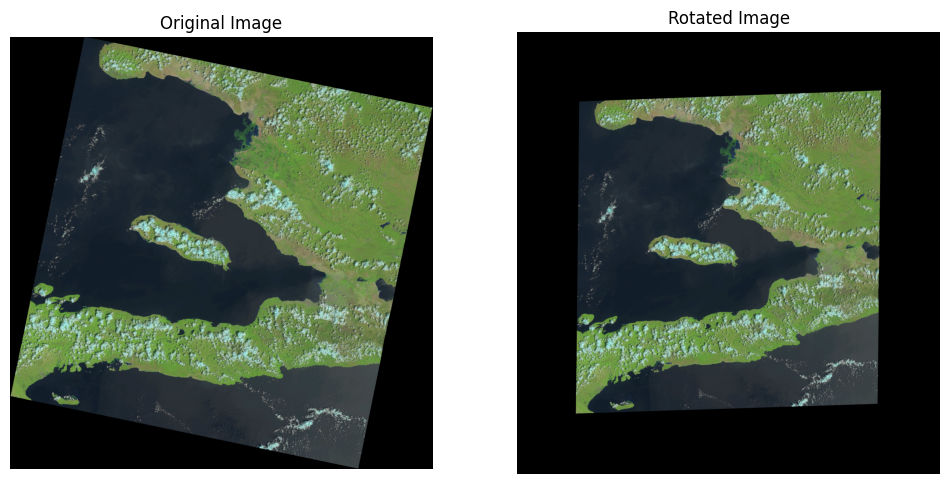

In [92]:
import matplotlib.image as mpimg

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
img_original = mpimg.imread(resized_image_path)
ax[0].imshow(img_original)
ax[0].set_title("Original Image")
ax[0].axis('off')

# Rotated image
img_rotated = mpimg.imread(rotated_image_path)
ax[1].imshow(img_rotated)
ax[1].set_title("Rotated Image")
ax[1].axis('off')

plt.show()

#### Rotate using GeoTransform and gdal.Warp

- https://en.wikipedia.org/wiki/World_file
- https://digital-geography.com/python-for-geospatial-data-analysis-part-iv/

In [89]:
sample_folder_path = "D:/CMU/Spacecraft/LandSat/landsat_c2_l1_sample/"
file = os.path.join(sample_folder_path, 'LC08_L1TP_009047_20230914_20230919_02_T1_refl.tif')

output_path = "GDAL_output"
rotated_image_path = os.path.join(output_path, 'rotated_image.tif')
resized_image_path = os.path.join(output_path, 'resized_image.tif')
#resized_image_path = file

def raster_center(raster):
    """This function return the pixel coordinates of the raster center 
    """

    # We get the size (in pixels) of the raster
    # using gdal
    width, height = raster.RasterXSize, raster.RasterYSize

    # We calculate the middle of raster
    xmed = width / 2
    ymed = height / 2

    return (xmed, ymed)


dataset_src = gdal.Open(resized_image_path)

# For no overwriting the original raster I make a copy

# I Get the reading/writing driver (GTIFF)
driver = gdal.GetDriverByName("GTiff")
# A new raster, the destination file, is created.
# This raster is a copy of the source raster (same size, values...)
datase_dst = driver.CreateCopy(rotated_image_path, dataset_src, strict=0)

# Now we can rotate the raster

# First step, we get the affine tranformation matrix of the initial fine
# More info here : https://gdal.org/tutorials/geotransforms_tut.html#geotransforms-tut
gt_affine = dataset_src.GetGeoTransform()
print(f"GetGeoTransform() before rotating: ", dataset_src.GetGeoTransform())

GeoTransform = list(gt_affine)

A = GeoTransform[1]
E = GeoTransform[5]
B = 5
D = -5
GeoTransform[1] = sqrt((A**2) + (D**2))
GeoTransform[2] = B
GeoTransform[4] = D
GeoTransform[5] = sqrt((B**2) + (E**2))
GeoTransform = tuple(GeoTransform)
datase_dst.SetGeoTransform(GeoTransform)  # write GeoTransform to image
print(f"GetGeoTransform() during rotating: ", datase_dst.GetGeoTransform())

# Now warp (resample) the dataset to effectively apply the rotation to the raster data
#warp_options = gdal.WarpOptions(resampleAlg=gdal.GRA_Bilinear, 
##                                dstSRS=dataset_src.GetProjection(), 
#                                srcAlpha=False)

original_bounds = (
    GeoTransform[0],
    GeoTransform[3],
    GeoTransform[0] + (dataset_src.RasterXSize * GeoTransform[1]),
    GeoTransform[3] + (dataset_src.RasterYSize * GeoTransform[5]),
)
warp_options = gdal.WarpOptions(
    resampleAlg=gdal.GRA_Bilinear, 
    dstSRS=dataset_src.GetProjection(), 
    srcAlpha=False,
    outputBounds=original_bounds,  # desired output bounds
    xRes=GeoTransform[1],  # desired pixel size in x direction
    yRes=abs(GeoTransform[5]),  # desired pixel size in y direction (absolute value)
    outputBoundsSRS=dataset_src.GetProjection()  # Ensure it’s in the correct SRS
)
gdal.Warp(rotated_image_path, 
          datase_dst, 
          options=warp_options)

datase_src = None
datase_dst = None

roated = gdal.Open(rotated_image_path)
print(f"GetGeoTransform() after rotating: ", roated.GetGeoTransform())
roated = None

GetGeoTransform() before rotating:  (614085.0, 87.2800925925926, 0.0, 2193915.0, 4.0, -87.29433962264152)
center of image:  (1296.0, 1325.0)
GetGeoTransform() during rotating:  (614085.0, 87.42319236319122, 5.0, 2193915.0, -5.0, 87.4374160766035)
GetGeoTransform() after rotating:  (614085.0, 87.42319236319122, 0.0, 2425624.1526029995, 0.0, -87.4374160766035)


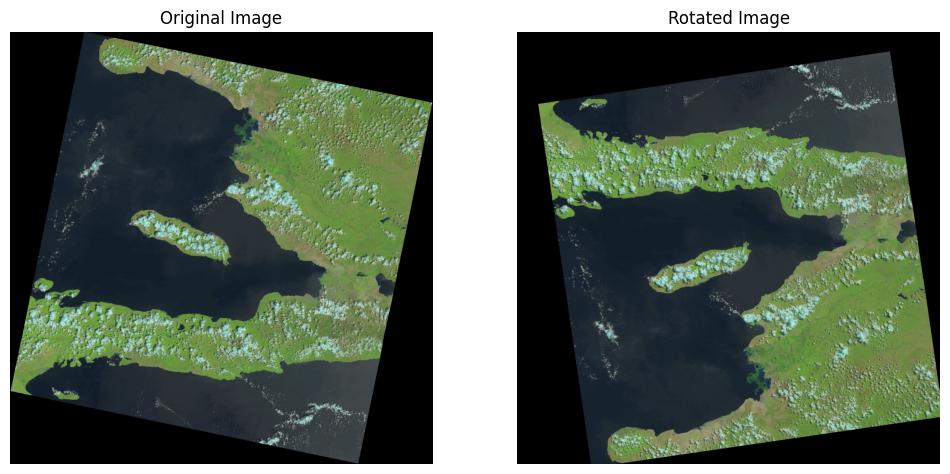

In [90]:
import matplotlib.image as mpimg

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
img_original = mpimg.imread(resized_image_path)
ax[0].imshow(img_original)
ax[0].set_title("Original Image")
ax[0].axis('off')

# Rotated image
img_rotated = mpimg.imread(rotated_image_path)
ax[1].imshow(img_rotated)
ax[1].set_title("Rotated Image")
ax[1].axis('off')

plt.show()


#### Random Side Notes...

GeoTransform[1] = X_pixel_size / cos(ROLL_ANGLE)
GeoTransform[2] = -1*X_pixel_size  / sin(ROLL_ANGLE)
GeoTransform[4] = Y_pixel_size / sin(ROLL_ANGLE)
GeoTransform[5] = Y_pixel_size / cos(ROLL_ANGLE)
GeoTransform = tuple(GeoTransform)
datase_dst.SetGeoTransform(GeoTransform)  # write GeoTransform to image

geotransform[0] = C
geotransform[1] = A
geotransform[2] = B
geotransform[3] = F
geotransform[4] = D
geotransform[5] = E

GetGeoTransform() before rotating:  
C = 614085.0
A = 30
B = 0.0
F = 2193915.0
D = 0.0
E = -30.0
